In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import time 
import scipy
import investpy
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

# Import data

In [2]:
ft = yf.download("CL=F RB=F HO=F NG=F ESSO.BK BCP.BK",start="2010-01-02",end="2020-08-31")
ft.fillna(method='bfill', inplace=True)
ft = ft.dropna()
ft = ft['Adj Close']
ft.head()

[*********************100%***********************]  6 of 6 completed


,BCP.BK,CL=F,ESSO.BK,HO=F,NG=F,RB=F
Date,,,,,,
2010-01-04,8.627183,81.510002,5.389438,2.1905,5.884,2.1044
2010-01-05,8.685084,81.769997,5.389438,2.1941,5.637,2.1250
2010-01-06,8.627183,83.180000,5.389438,2.2032,6.009,2.1366
2010-01-07,8.627183,82.660004,5.431874,2.1836,5.806,2.1349
2010-01-08,8.569283,82.750000,5.431874,2.2003,5.749,2.1553


In [3]:
st = yf.download("PTTEP.BK TVO.BK SCC.BK BTS.BK TNPC.BK",start="2010-01-02",end="2020-08-31")
st.fillna(method='bfill', inplace=True)
st = st.dropna()
st = st['Adj Close']
st.head()

[*********************100%***********************]  5 of 5 completed


,BTS.BK,PTTEP.BK,SCC.BK,TNPC.BK,TVO.BK
Date,,,,,
2010-01-04,2.281962,91.686096,159.190170,0.380774,8.899861
2010-01-05,2.281962,92.628090,159.190170,0.380774,8.899861
2010-01-06,2.243924,93.570053,157.140518,0.380774,8.949582
2010-01-07,2.243924,92.628090,154.407623,0.380774,8.999301
2010-01-08,2.243924,93.256287,155.090866,0.380774,9.049023


In [4]:
PTT = ft.join(st['PTTEP.BK'])
PTT = PTT.dropna()
PTT

,BCP.BK,CL=F,ESSO.BK,HO=F,NG=F,RB=F,PTTEP.BK
Date,,,,,,,
2010-01-04,8.627183,81.510002,5.389438,2.1905,5.884,2.1044,91.686096
2010-01-05,8.685084,81.769997,5.389438,2.1941,5.637,2.1250,92.628090
2010-01-06,8.627183,83.180000,5.389438,2.2032,6.009,2.1366,93.570053
2010-01-07,8.627183,82.660004,5.431874,2.1836,5.806,2.1349,92.628090
2010-01-08,8.569283,82.750000,5.431874,2.2003,5.749,2.1553,93.256287
...,...,...,...,...,...,...,...
2020-08-24,17.600000,42.619999,6.700000,1.2476,2.513,1.3671,90.500000
2020-08-25,17.299999,43.349998,6.900000,1.2601,2.489,1.3959,91.250000
2020-08-26,17.500000,43.389999,6.850000,1.2447,2.461,1.3606,91.250000


In [5]:
# df = pd.read_csv('BZ=F.csv')
# df = df.rename(columns={'วันเดือนปี' : 'Date','ล่าสุด' : 'BZ=F'})
# df = df[['BZ=F']]

# PTT = PTT.merge(df)
# PTT

# Visualize the Time Series

c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


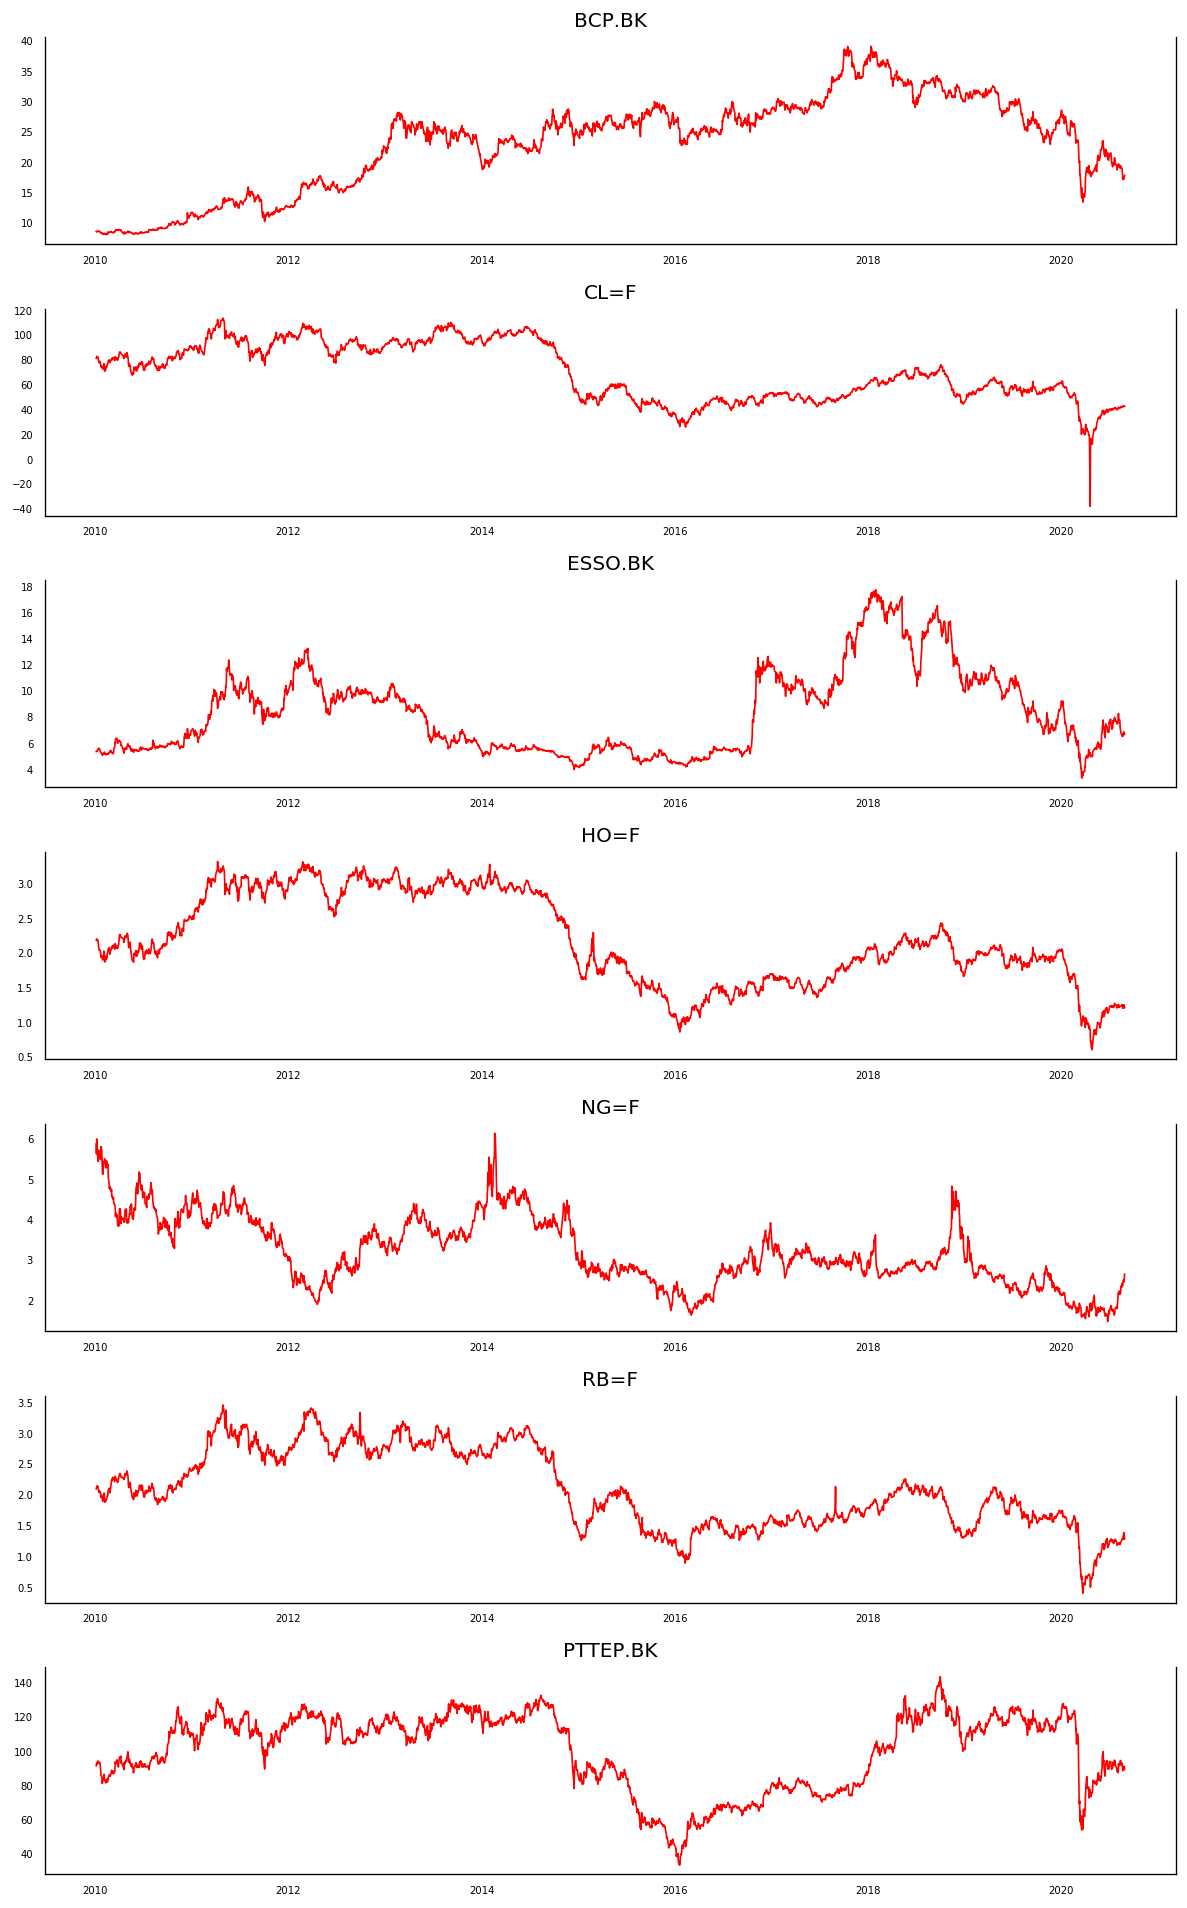

In [6]:
fig, axes = plt.subplots(nrows=len(PTT.columns), ncols=1, dpi=120, figsize=(10,16))
for i, ax in enumerate(axes.flatten()):
    data = PTT[PTT.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(PTT.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# Correlation

In [7]:
PTT.corr()

,BCP.BK,CL=F,ESSO.BK,HO=F,NG=F,RB=F,PTTEP.BK
BCP.BK,1.000000,-0.460942,0.431908,-0.373525,-0.427725,-0.404848,-0.142434
CL=F,-0.460942,1.000000,0.058329,0.966551,0.643472,0.962542,0.726802
ESSO.BK,0.431908,0.058329,1.000000,0.141527,-0.132455,0.109902,0.315066
HO=F,-0.373525,0.966551,0.141527,1.000000,0.568315,0.964067,0.758552
NG=F,-0.427725,0.643472,-0.132455,0.568315,1.000000,0.555415,0.347233
RB=F,-0.404848,0.962542,0.109902,0.964067,0.555415,1.000000,0.685989
PTTEP.BK,-0.142434,0.726802,0.315066,0.758552,0.347233,0.685989,1.000000


# Testing Causation using Granger’s Causality Test

In [8]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=24
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    PTT = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in PTT.columns:
        for r in PTT.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            PTT.loc[r, c] = min_p_value
    PTT.columns = [var + '_x' for var in variables]
    PTT.index = [var + '_y' for var in variables]
    return PTT

grangers_causation_matrix(PTT, variables = PTT.columns)   

c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, bu

,BCP.BK_x,CL=F_x,ESSO.BK_x,HO=F_x,NG=F_x,RB=F_x,PTTEP.BK_x
BCP.BK_y,1.0000,0.0000,0.0001,0.0000,0.6604,0.0000,0.0703
CL=F_y,0.0000,1.0000,0.0618,0.0000,0.1520,0.0000,0.0000
ESSO.BK_y,0.0041,0.0007,1.0000,0.0000,0.2089,0.0006,0.0151
HO=F_y,0.0643,0.0000,0.0433,1.0000,0.0173,0.0009,0.0853
NG=F_y,0.3198,0.0036,0.0208,0.0034,1.0000,0.0056,0.0371
RB=F_y,0.0431,0.0000,0.1315,0.0076,0.0105,1.0000,0.0053
PTTEP.BK_y,0.0136,0.0000,0.0736,0.0000,0.1567,0.0000,1.0000


# Cointegration Test

In [9]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(PTT, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(PTT,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(PTT.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(PTT)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
BCP.BK ::  105.23    > 111.7797  =>   False
CL=F   ::  67.59     > 83.9383   =>   False
ESSO.BK ::  39.05     > 60.0627   =>   False
HO=F   ::  22.87     > 40.1749   =>   False
NG=F   ::  13.86     > 24.2761   =>   False
RB=F   ::  5.54      > 12.3212   =>   False
PTTEP.BK ::  0.69      > 4.1296    =>   False


# Split the Series into Training and Testing Data

In [10]:
nobs = 7
ft_train, ft_test = PTT[0:-nobs], PTT[-nobs:]

# Check size
print(ft_train.shape)  
print(ft_test.shape)  
ft_train

(2596, 7)
(7, 7)


,BCP.BK,CL=F,ESSO.BK,HO=F,NG=F,RB=F,PTTEP.BK
Date,,,,,,,
2010-01-04,8.627183,81.510002,5.389438,2.1905,5.884,2.1044,91.686096
2010-01-05,8.685084,81.769997,5.389438,2.1941,5.637,2.1250,92.628090
2010-01-06,8.627183,83.180000,5.389438,2.2032,6.009,2.1366,93.570053
2010-01-07,8.627183,82.660004,5.431874,2.1836,5.806,2.1349,92.628090
2010-01-08,8.569283,82.750000,5.431874,2.2003,5.749,2.1553,93.256287
...,...,...,...,...,...,...,...
2020-08-13,19.500000,42.240002,6.950000,1.2381,2.182,1.2348,94.750000
2020-08-14,19.100000,42.009998,6.800000,1.2367,2.356,1.2446,92.000000
2020-08-17,19.100000,42.889999,6.700000,1.2391,2.339,1.2700,92.000000


# Check for Stationarity and Make the Time Series Stationary

In [11]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [12]:
# ADF Test on each column
for name, column in ft_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "BCP.BK" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.9706
 No. Lags Chosen       = 9
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.2996. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "CL=F" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.4855
 No. Lags Chosen       = 7
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.5407. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "ESSO.BK" 
    -----------------------------------------------
 Null Hypothesis: Data has un

In [13]:
# 1st difference
ft_differenced = ft_train.diff().dropna()

In [14]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in ft_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "BCP.BK" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -16.6668
 No. Lags Chosen       = 8
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CL=F" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -18.759
 No. Lags Chosen       = 6
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ESSO.BK" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    =

In [15]:
# Second Differencing
ft_differenced = ft_differenced.diff().dropna()

In [16]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in ft_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "BCP.BK" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -16.9584
 No. Lags Chosen       = 25
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CL=F" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -17.0601
 No. Lags Chosen       = 28
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ESSO.BK" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level  

# Select the Order (P) of VAR model

In [17]:
model = VAR(ft_differenced)
for i in list(range(1,24)):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -17.599885270864313
BIC :  -17.473316831222906
FPE :  2.2723069890150074e-08
HQIC:  -17.554020159812662 

Lag Order = 2
AIC :  -18.584250276628122
BIC :  -18.346858520827745
FPE :  8.491082242105787e-09
HQIC:  -18.49822399129709 

Lag Order = 3
AIC :  -19.105439656092052
BIC :  -18.757153637641043
FPE :  5.042132147330752e-09
HQIC:  -18.979224910656733 

Lag Order = 4
AIC :  -19.447916509829373
BIC :  -18.988665208515553
FPE :  3.5799752197015905e-09
HQIC:  -19.28148598928543 

Lag Order = 5
AIC :  -19.66258557384368
BIC :  -19.092297895629162
FPE :  2.8883713915064864e-09
HQIC:  -19.45591193396494 

Lag Order = 6
AIC :  -19.856858381184303
BIC :  -19.175463158100122
FPE :  2.378402073510534e-09
HQIC:  -19.609914248480287 

Lag Order = 7
AIC :  -19.969837281191765
BIC :  -19.17726327123231
FPE :  2.1243423143953316e-09
HQIC:  -19.6825952528651 

Lag Order = 8


c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


AIC :  -20.049557890703376
BIC :  -19.14573377772063
FPE :  1.9615950337227527e-09
HQIC:  -19.721990534607176 

Lag Order = 9
AIC :  -20.10854114763656
BIC :  -19.09339554123414
FPE :  1.8492784516188561e-09
HQIC:  -19.7406210022317 

Lag Order = 10
AIC :  -20.16505115251361
BIC :  -19.038512587940644
FPE :  1.7477190447367167e-09
HQIC:  -19.756750726825924 

Lag Order = 11
AIC :  -20.207634826741756
BIC :  -18.969631764786538
FPE :  1.6749102550608112e-09
HQIC:  -19.75892660031917 

Lag Order = 12
AIC :  -20.242952935061048
BIC :  -18.8934137619445
FPE :  1.6168495002019186e-09
HQIC:  -19.753809357930624 

Lag Order = 13
AIC :  -20.276339318312107
BIC :  -18.815192345581075
FPE :  1.5638301427552246e-09
HQIC:  -19.746732810937004 

Lag Order = 14
AIC :  -20.281085094687896
BIC :  -18.708258559108224
FPE :  1.5565076735686803e-09
HQIC:  -19.71098804792426 

Lag Order = 15
AIC :  -20.29473403712762
BIC :  -18.610156100577036
FPE :  1.535500133040176e-09
HQIC:  -19.684118812181392 

Lag 

In [18]:
#Lag Order = 3
x = model.select_order(maxlags=4)
x.summary()

,AIC,BIC,FPE,HQIC
0,-15.21,-15.19,2.488e-07,-15.20
1,-17.60,-17.47,2.282e-08,-17.55
2,-18.58,-18.35,8.503e-09,-18.50
3,-19.11,-18.76,5.042e-09,-18.98
4,-19.45*,-18.99*,3.580e-09*,-19.28*


# Train the VAR Model of Selected Order(p)

In [19]:
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 30, Oct, 2020
Time:                     10:47:58
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -18.7572
Nobs:                     2591.00    HQIC:                  -18.9792
Log likelihood:          -830.191    FPE:                5.04213e-09
AIC:                     -19.1054    Det(Omega_mle):     4.75237e-09
--------------------------------------------------------------------
Results for equation BCP.BK
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.000203         0.009542           -0.021           0.983
L1.BCP.BK          -0.794778         0.021248          -37.406           0.000
L1.CL=F             0.011395         0.004889            2.331     

# Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

In [20]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(PTT.columns, out):
    print( col,':', round(val, 2))

BCP.BK : 2.13
CL=F : 2.15
ESSO.BK : 2.08
HO=F : 2.11
NG=F : 2.1
RB=F : 2.12
PTTEP.BK : 2.08


# Forecast VAR model using statsmodels

In [21]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = ft_differenced.values[-lag_order:]
forecast_input

3


array([[ 0.39999962,  1.11000443,  0.04999924,  0.00379992, -0.19099998,
         0.01559985,  2.75      ],
       [ 0.        , -0.88000107,  0.15000057,  0.01890016,  0.09500003,
        -0.01239991,  1.25      ],
       [-0.5       ,  0.04000092, -0.25      , -0.03070009, -0.06900001,
        -0.00549996, -2.5       ]])

In [22]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
ft_forecast = pd.DataFrame(fc, index=PTT.index[-nobs:], columns=PTT.columns + '_2d')
ft_forecast


,BCP.BK_2d,CL=F_2d,ESSO.BK_2d,HO=F_2d,NG=F_2d,RB=F_2d,PTTEP.BK_2d
Date,,,,,,,
2020-08-20,0.306632,-0.001013,0.101059,0.008812,0.050717,0.003684,0.727439
2020-08-21,-0.015689,0.230379,0.000574,0.005806,-0.024687,0.006418,0.257654
2020-08-24,-0.026423,-0.184570,0.006928,0.000866,0.009446,-0.004443,-0.051489
2020-08-25,-0.030098,0.058500,-0.021537,-0.007057,-0.007160,-0.002483,-0.125954
2020-08-26,0.040729,-0.064618,0.011734,0.003021,0.007399,0.002583,0.041279
2020-08-27,-0.018119,0.094797,-0.003099,0.001403,-0.004957,0.000895,-0.003891
2020-08-28,0.001402,-0.050614,0.001600,-0.000558,0.001997,-0.001339,0.023496


# Invert the transformation to get the real forecast

In [23]:
def invert_transformation(ft_train, ft_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    ft_fc = ft_forecast.copy()
    columns = ft_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            ft_fc[str(col)+'_1d'] = (ft_train[col].iloc[-1]-ft_train[col].iloc[-2]) + ft_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        ft_fc[str(col)+'_forecast'] = ft_train[col].iloc[-1] + ft_fc[str(col)+'_1d'].cumsum()
    return ft_fc

In [24]:
ft_results = invert_transformation(ft_train, ft_forecast, second_diff=True)        
ft_results.loc[:, ["CL=F_forecast" ,"HO=F_forecast", "NG=F_forecast", "RB=F_forecast" ,"PTTEP.BK_forecast" ]]

,CL=F_forecast,HO=F_forecast,NG=F_forecast,RB=F_forecast,PTTEP.BK_forecast
Date,,,,,
2020-08-20,42.968988,1.250412,2.485717,1.301685,91.477439
2020-08-21,43.238355,1.255631,2.520748,1.319287,91.212533
2020-08-24,43.323152,1.261715,2.565224,1.332446,90.896137
2020-08-25,43.466449,1.260742,2.602540,1.343122,90.453788
2020-08-26,43.545127,1.262789,2.647255,1.356381,90.052718
2020-08-27,43.718603,1.266240,2.687014,1.370536,89.647757
2020-08-28,43.841465,1.269133,2.728769,1.383351,89.266292


# Plot of Forecast vs Actuals

Forecast Accuracy of: PTTEP
mape (Mean absolute percentage error) :  1.2937
mae (Mean Absolute Error) :  1.1665
rmse (Root Mean Square Error) :  1.3676
mase (Mean absolute scaled error) :  0.8387


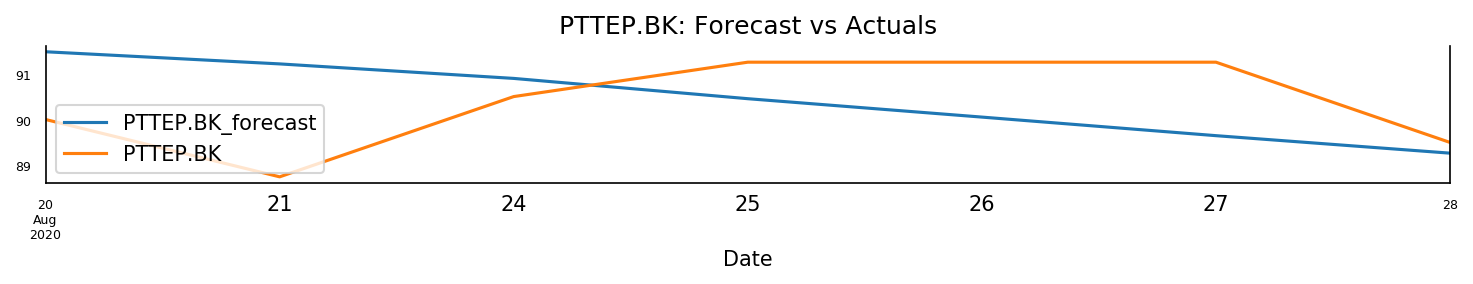

In [25]:

fig, axes = plt.subplots(nrows=1, ncols=1, dpi=150, figsize=(10,2))
# fig, axes = plt.subplots(nrows=int(len(PTT.columns)), ncols=1, dpi=150, figsize=(10,10))

# for i, (col,ax) in enumerate(zip(PTT.columns, axes.flatten())):

ft_results['PTTEP.BK'+'_forecast'].plot(legend=True).autoscale(axis='x',tight=True)
ft_test['PTTEP.BK'][-nobs:].plot(legend=True );
axes.set_title('PTTEP.BK' + ": Forecast vs Actuals")
axes.xaxis.set_ticks_position('none')
axes.yaxis.set_ticks_position('none')
axes.spines["top"].set_alpha(0)
axes.tick_params(labelsize=6)

from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual,train):
    
    n = train.shape[0]
    d = np.abs(  np.diff( train) ).sum()/(n-1)
    
    mase = np.mean(np.abs(actual - forecast ))/d
    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape (Mean absolute percentage error)':mape*100,  'mae (Mean Absolute Error)': mae, 'rmse (Root Mean Square Error)':rmse, 'mase (Mean absolute scaled error)':mase })
plt.tight_layout();
print('Forecast Accuracy of: PTTEP')
accuracy_prod = forecast_accuracy(ft_results['PTTEP.BK_forecast'].values, ft_test['PTTEP.BK'],ft_train['PTTEP.BK'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

#     ft_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
#     ft_test[col][-nobs:].plot(legend=True, ax=ax);
#     ax.set_title(col + ": Forecast vs Actuals")
#     ax.xaxis.set_ticks_position('none')
#     ax.yaxis.set_ticks_position('none')
#     ax.spines["top"].set_alpha(0)
#     ax.tick_params(labelsize=6)



In [26]:
# PTT.tail()

In [27]:
# ft_results.tail()

# Evaluate the Forecasts

In [28]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape*100,  'mae': mae, 'rmse':rmse })

print('Forecast Accuracy of: PTT')
accuracy_prod = forecast_accuracy(ft_results['PTTEP.BK_forecast'].values, ft_test['PTTEP.BK'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: CC=F')
# accuracy_prod = forecast_accuracy(ft_results['CC=F_forecast'].values, ft_test['CC=F'])
# for k, v in accuracy_prod.items():
#     print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: KC=F')
# accuracy_prod = forecast_accuracy(ft_results['KC=F_forecast'].values, ft_test['KC=F'])
# for k, v in accuracy_prod.items():
#     print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: HG=F')
# accuracy_prod = forecast_accuracy(ft_results['HG=F_forecast'].values, ft_test['HG=F'])
# for k, v in accuracy_prod.items():
#     print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: PL=F')
# accuracy_prod = forecast_accuracy(ft_results['PL=F_forecast'].values, ft_test['PL=F'])
# for k, v in accuracy_prod.items():
#     print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: ALI=F')
# accuracy_prod = forecast_accuracy(ft_results['ALI=F_forecast'].values, ft_test['ALI=F'])
# for k, v in accuracy_prod.items():
#     print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: SI=F')
# accuracy_prod = forecast_accuracy(ft_results['SI=F_forecast'].values, ft_test['SI=F'])
# for k, v in accuracy_prod.items():
#     print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: GC=F')
# accuracy_prod = forecast_accuracy(ft_results['GC=F_forecast'].values, ft_test['GC=F'])
# for k, v in accuracy_prod.items():
#     print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: NG=F')
# accuracy_prod = forecast_accuracy(ft_results['NG=F_forecast'].values, ft_test['NG=F'])
# for k, v in accuracy_prod.items():
#     print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: CL=F')
# accuracy_prod = forecast_accuracy(ft_results['CL=F_forecast'].values, ft_test['CL=F'])
# for k, v in accuracy_prod.items():
#     print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: AAPL')
# accuracy_prod = forecast_accuracy(ft_results['AAPL_forecast'].values, ft_test['AAPL'])
# for k, v in accuracy_prod.items():
#     print(k, ': ', round(v,4))

Forecast Accuracy of: PTT
mape :  1.2937
mae :  1.1665
rmse :  1.3676
